In [2]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone.core.labels import Detection
from PIL import Image

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data

import torchvision
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn, MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import numpy as np

import os
import importlib
import sys
from pathlib import Path
from datetime import datetime

import utils
import train
from train import train_one_epoch, evaluate
import transforms as T
importlib.reload(T)

here = os.getcwd()
sys.path.append(os.path.join(here, '..'))
import DatasetLoaders
importlib.reload(DatasetLoaders)
from DatasetLoaders import HRSIDSegmentationDataset
import MaskRCNN_model_wrapper
importlib.reload(MaskRCNN_model_wrapper)
# from MaskRCNN_model_wrapper import MaskRCNNWrapper
from MaskRCNN_model_wrapper import do_training, save_model, get_model
import fiftyone_evaluation as fiftyone_evaluation



In [3]:
# get path to directory above
p = Path()
top_dir = p.absolute().parents[1]
top_dir

PosixPath('/home/k3vinli/ENEE439/Capstone')

In [4]:
name = "HRSID_train"
if name in fo.list_datasets():
    dataset_train = fo.load_dataset(name)
else:
    dataset_dir = top_dir / "Datasets" / "HRSID"
    label_path = top_dir / "Datasets"/ "HRSID" / "annotations" / "train2017.json"
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_train = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
        labels_path=label_path
    )

 100% |███████████████| 3642/3642 [21.2s elapsed, 0s remaining, 159.7 samples/s]      


In [5]:
name = "HRSID_test"
if name in fo.list_datasets():
    dataset_test = fo.load_dataset(name)
else:
    dataset_dir = top_dir / "Datasets" / "HRSID"
    label_path = top_dir / "Datasets"/ "HRSID" / "annotations" / "test2017.json"
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_test = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
        labels_path=label_path
    )

 100% |███████████████| 1961/1961 [11.2s elapsed, 0s remaining, 112.8 samples/s]     


In [6]:
dataset_train.compute_metadata()
dataset_test.compute_metadata()


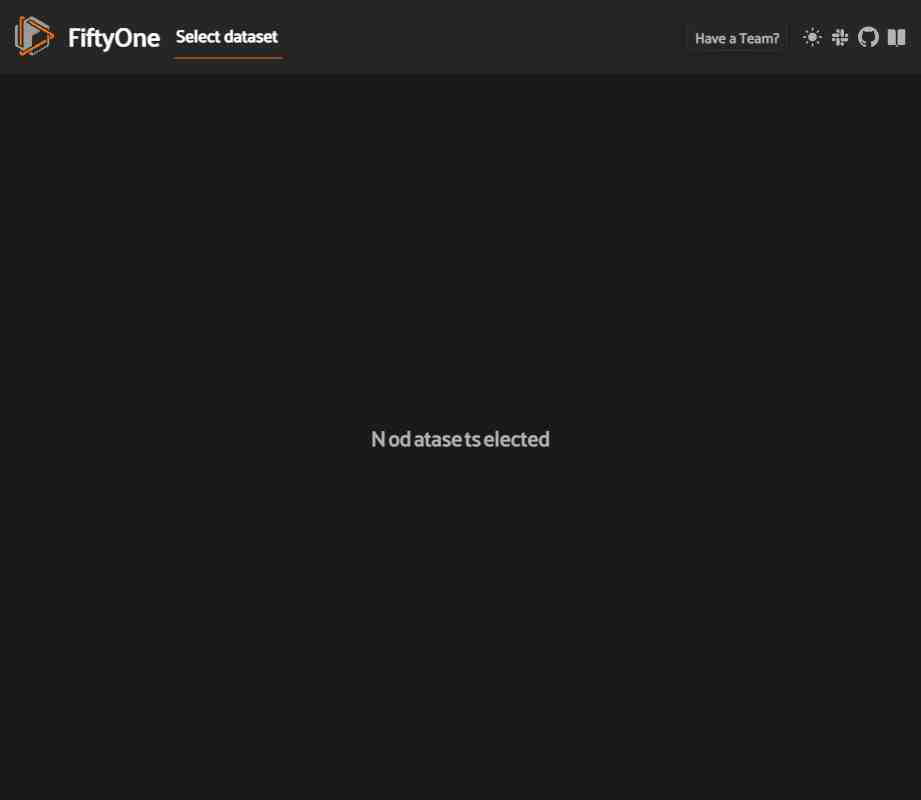

In [7]:
session = fo.launch_app()

In [8]:
def get_transform_lee():
    transforms = []

    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.LeeFilter(5))
    
    return T.Compose(transforms)

In [9]:
model = get_model(2, True)

In [10]:
HRSID_torch_train_lee = HRSIDSegmentationDataset(dataset_train, transforms=get_transform_lee())
HRSID_torch_test_lee = HRSIDSegmentationDataset(dataset_test, transforms=get_transform_lee())

In [11]:
do_training(model, HRSID_torch_train_lee, HRSID_torch_test_lee, num_epochs=45, step_size=15)

Using cuda


/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)
/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)
/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely s

Epoch: [0]  [  0/911]  eta: 1:53:32  lr: 0.000010  loss: 5.3195 (5.3195)  loss_classifier: 0.4150 (0.4150)  loss_box_reg: 0.0863 (0.0863)  loss_mask: 2.4571 (2.4571)  loss_objectness: 2.0857 (2.0857)  loss_rpn_box_reg: 0.2754 (0.2754)  time: 7.4775  data: 3.6880  max mem: 2677
Epoch: [0]  [ 10/911]  eta: 0:15:38  lr: 0.000065  loss: 2.8713 (3.2226)  loss_classifier: 0.3902 (0.3887)  loss_box_reg: 0.1859 (0.1591)  loss_mask: 1.9815 (1.9698)  loss_objectness: 0.2574 (0.6263)  loss_rpn_box_reg: 0.0346 (0.0787)  time: 1.0421  data: 0.3457  max mem: 2840
Epoch: [0]  [ 20/911]  eta: 0:10:53  lr: 0.000120  loss: 2.7336 (3.0950)  loss_classifier: 0.3626 (0.3525)  loss_box_reg: 0.1232 (0.1440)  loss_mask: 1.6844 (1.7504)  loss_objectness: 0.1269 (0.7586)  loss_rpn_box_reg: 0.0268 (0.0896)  time: 0.3961  data: 0.0119  max mem: 2882
Epoch: [0]  [ 30/911]  eta: 0:09:11  lr: 0.000175  loss: 1.7300 (2.6358)  loss_classifier: 0.2665 (0.3203)  loss_box_reg: 0.1247 (0.1490)  loss_mask: 1.2706 (1.4739) 

/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)


creating index...
index created!
Test:  [  0/981]  eta: 0:26:03  model_time: 0.3299 (0.3299)  evaluator_time: 0.0974 (0.0974)  time: 1.5936  data: 1.1610  max mem: 4141
Test:  [100/981]  eta: 0:02:26  model_time: 0.0948 (0.1115)  evaluator_time: 0.0130 (0.0197)  time: 0.1316  data: 0.0116  max mem: 4141
Test:  [200/981]  eta: 0:02:12  model_time: 0.0993 (0.1086)  evaluator_time: 0.0130 (0.0204)  time: 0.2055  data: 0.0622  max mem: 4141
Test:  [300/981]  eta: 0:02:00  model_time: 0.0963 (0.1085)  evaluator_time: 0.0162 (0.0226)  time: 0.1691  data: 0.0278  max mem: 4141
Test:  [400/981]  eta: 0:01:39  model_time: 0.0931 (0.1070)  evaluator_time: 0.0134 (0.0225)  time: 0.1266  data: 0.0095  max mem: 4141
Test:  [500/981]  eta: 0:01:18  model_time: 0.1040 (0.1057)  evaluator_time: 0.0218 (0.0220)  time: 0.1428  data: 0.0107  max mem: 4141
Test:  [600/981]  eta: 0:01:00  model_time: 0.0991 (0.1048)  evaluator_time: 0.0230 (0.0214)  time: 0.1507  data: 0.0188  max mem: 4141
Test:  [700/981

In [ ]:
save_model(model, "maskrcnn_hrsid_pre_lee_e40_lr005_m5_step15.pt")

In [ ]:
fiftyone_evaluation.add_detections(model, HRSID_torch_test_lee, dataset_test, field_name="predictions_lee")

In [ ]:
results = fo.evaluate_detections(
    dataset_test, 
    "predictions_lee", 
    classes=["ship"],
    eval_key="eval", 
    compute_mAP=True,
    gt_field='detections'
)

In [ ]:
results.mAP()

In [ ]:
results.print_report()

In [ ]:
def get_transform_HF_jitter():
    transforms = []

    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.RandomHorizontalFlip())
    transforms.append(T.ScaleJitter((800, 800)))
    
    return T.Compose(transforms)

In [ ]:
model = get_model(2, True)

In [ ]:
HRSID_torch_train_HF_jitter = HRSIDSegmentationDataset(dataset_train, transforms=get_transform_HF_jitter())
HRSID_torch_test_HF_jitter = HRSIDSegmentationDataset(dataset_test, transforms=get_transform_HF_jitter())

In [ ]:
do_training(model, HRSID_torch_train_HF_jitter, HRSID_torch_test_HF_jitter, num_epochs=45, step_size=15)

In [ ]:
save_model(model, "maskrcnn_hrsid_pre_HF_jitter_e45_lr005_m5_step15.pt")

In [ ]:
fiftyone_evaluation.add_detections(model, HRSID_torch_test_lee, dataset_test, field_name="predictions_HF_jitter")

In [ ]:
results = fo.evaluate_detections(
    dataset_test, 
    "predictions_HF_jitter", 
    classes=["ship"],
    eval_key="eval", 
    compute_mAP=True,
    gt_field='detections'
)

In [ ]:
results.mAP()

In [ ]:
results.print_report()